# Traffic Sign Classification

## Dataset

The dataset we’ll be using to train our own custom traffic sign classifier is the German Traffic Sign Benchmark https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed.

## Goal

Classify images of traffic signs.

## About the dataset

The dataset contains preprocessed data for Traffic Signs saved into some pickle files.

The images are in the following files:

- train.p
- valid.p
- test.p

There are about 34799 images. There are also a csv file with the list of sign categories (labels.csv).

## Data Preparation

I've converted the database into images and save them into some directories with the names from labels.csv.

## Model

I created a model using Keras libraries, layers and optimizers. I tried some parameters to find the best model.

## Export model

The final model is exported to h5 file and used in dockerized python script.

In [201]:
!python3 --version

Python 3.7.12


In [202]:
import os
import zipfile

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, AvgPool2D, BatchNormalization, Reshape

from sklearn.model_selection import train_test_split
import tqdm
import shutil
import pickle

import numpy as np
import pandas as pd
from pathlib import Path
from os import path
from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

Download the dataset from source

In [203]:
# Load dataset
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip

# Load labels
!wget https://raw.githubusercontent.com/asarzina/mlzoomcamp-capstone-project/master/labels.csv

--2021-12-14 09:08:31--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 65.8.27.131, 65.8.27.57, 65.8.27.175, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|65.8.27.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip.1’

traffic-signs-data. 100%[===================>] 117.80M  49.7MB/s    in 2.4s    

2021-12-14 09:08:34 (49.7 MB/s) - ‘traffic-signs-data.zip.1’ saved [123524425/123524425]

--2021-12-14 09:08:34--  https://raw.githubusercontent.com/asarzina/mlzoomcamp-capstone-project/master/labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HT

In [204]:
!ls -l

total 241280
-rw-r--r-- 1 root root       998 Dec 14 07:20 labels.csv
-rw-r--r-- 1 root root       998 Dec 14 09:08 labels.csv.1
drwxr-xr-x 1 root root      4096 Dec  3 14:33 sample_data
-rw-r--r-- 1 root root 123524425 Feb  6  2017 traffic-signs-data.zip
-rw-r--r-- 1 root root 123524425 Feb  6  2017 traffic-signs-data.zip.1


## Data preparation

Extract the dataset

In [205]:
BASE_PATH = '../tmp/traffic-signs/'

In [206]:
zip_ref = zipfile.ZipFile("./traffic-signs-data.zip", 'r')
zip_ref.extractall(BASE_PATH)
zip_ref.close()

In [207]:
os.listdir(BASE_PATH)

['test',
 'validation',
 'valid.p',
 'train.p',
 'train',
 'valid',
 'test.p',
 'labels.csv']

In [208]:
shutil.copyfile('./labels.csv', BASE_PATH + 'labels.csv')

'../tmp/traffic-signs/labels.csv'

In [209]:
labels_df = pd.read_csv(BASE_PATH + 'labels.csv')
labels_df

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [210]:
# Get index only of object types
strings = list(labels_df.dtypes[labels_df.dtypes == 'object'].index)
strings

['SignName']

In [211]:
# values to lowercase
for col in strings:
  text = labels_df[col].str.lower()
  text = text.str.replace(' ', '_')
  text = text.str.replace('(', '')
  text = text.str.replace(')', '')
  text = text.str.replace('/', '')
  labels_df[col] = text

labels_df.head()

,ClassId,SignName
0,0,speed_limit_20kmh
1,1,speed_limit_30kmh
2,2,speed_limit_50kmh
3,3,speed_limit_60kmh
4,4,speed_limit_70kmh


In [212]:
training_file =  BASE_PATH + "train.p"
validation_file= BASE_PATH + "valid.p"
testing_file =   BASE_PATH + "test.p"

In [213]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [214]:
train.keys(), valid.keys(), test.keys()

(dict_keys(['coords', 'labels', 'features', 'sizes']),
 dict_keys(['coords', 'labels', 'features', 'sizes']),
 dict_keys(['sizes', 'coords', 'features', 'labels']))

In [215]:
len(train['coords']), len(train['labels']), len(train['features']), len(train['sizes'])

(34799, 34799, 34799, 34799)

In [216]:
train['features'][:1]

array([[[[28, 25, 24],
         [27, 24, 23],
         [27, 24, 22],
         ...,
         [32, 28, 24],
         [31, 27, 25],
         [31, 27, 26]],

        [[29, 26, 25],
         [27, 25, 23],
         [27, 25, 23],
         ...,
         [32, 28, 24],
         [31, 27, 24],
         [30, 27, 25]],

        [[28, 26, 26],
         [27, 25, 23],
         [26, 25, 23],
         ...,
         [32, 28, 24],
         [31, 27, 24],
         [30, 27, 25]],

        ...,

        [[27, 24, 23],
         [28, 25, 24],
         [30, 25, 24],
         ...,
         [27, 24, 23],
         [28, 24, 22],
         [29, 25, 22]],

        [[28, 23, 23],
         [29, 24, 24],
         [31, 25, 24],
         ...,
         [27, 24, 23],
         [28, 24, 22],
         [28, 24, 21]],

        [[29, 23, 23],
         [30, 24, 24],
         [32, 24, 23],
         ...,
         [27, 24, 22],
         [27, 23, 21],
         [26, 22, 20]]]], dtype=uint8)

In [217]:
train['labels'][:1]

array([41], dtype=uint8)

In [218]:
train['sizes'][:1]

array([[26, 25]], dtype=uint8)

In [219]:
labels = pd.DataFrame(train['labels'])
labels.value_counts()

2     2010
1     1980
13    1920
12    1890
38    1860
10    1800
4     1770
5     1650
25    1350
9     1320
7     1290
8     1260
3     1260
11    1170
35    1080
18    1080
17     990
31     690
14     690
33     599
15     540
26     540
28     480
23     450
30     390
34     360
16     360
6      360
22     330
36     330
20     300
40     300
21     270
39     270
29     240
24     240
42     210
41     210
27     210
32     210
19     180
37     180
0      180
dtype: int64

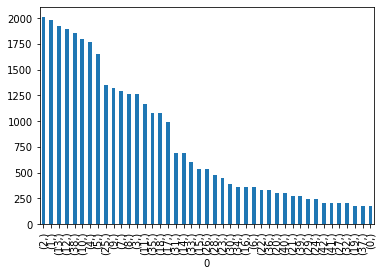

In [220]:
labels.value_counts().plot(kind='bar')
plt.show()  # density=False would make counts

### Create folders for train, validation and test

In [221]:
os.makedirs(BASE_PATH + 'train', exist_ok=True)
os.makedirs(BASE_PATH + 'validation', exist_ok=True)
os.makedirs(BASE_PATH + 'test', exist_ok=True)

### Move images to folders

In [222]:
def save_img_from_array(array, name):
  img = Image.fromarray(array)
  img.save(name)

In [223]:
def get_category_from_label(label):
  obj = labels_df[labels_df.ClassId == label]['SignName']
  return obj.values[0]

In [224]:
def save_images(data, type):
  saved_images = 0

  for index, [f,l] in enumerate(zip(data['features'], data['labels'])):
    category = get_category_from_label(l)

    path = f'{BASE_PATH}{type}/{category}'
    os.makedirs(path, exist_ok=True)

    fullpath = f'{path}/img_{index}.png'
    save_img_from_array(f, fullpath)
    saved_images += 1

  print(f'Images saved for {type}:', saved_images)

In [225]:
save_images(train, 'train')
save_images(valid, 'valid')
save_images(test, 'test')

Images saved for train: 34799
Images saved for valid: 4410
Images saved for test: 12630


In [256]:
categories = sorted(labels_df['SignName'].tolist())
categories

['ahead_only',
 'beware_of_icesnow',
 'bicycles_crossing',
 'bumpy_road',
 'children_crossing',
 'dangerous_curve_to_the_left',
 'dangerous_curve_to_the_right',
 'double_curve',
 'end_of_all_speed_and_passing_limits',
 'end_of_no_passing',
 'end_of_no_passing_by_vehicles_over_3.5_metric_tons',
 'end_of_speed_limit_80kmh',
 'general_caution',
 'go_straight_or_left',
 'go_straight_or_right',
 'keep_left',
 'keep_right',
 'no_entry',
 'no_passing',
 'no_passing_for_vehicles_over_3.5_metric_tons',
 'no_vehicles',
 'pedestrians',
 'priority_road',
 'right-of-way_at_the_next_intersection',
 'road_narrows_on_the_right',
 'road_work',
 'roundabout_mandatory',
 'slippery_road',
 'speed_limit_100kmh',
 'speed_limit_120kmh',
 'speed_limit_20kmh',
 'speed_limit_30kmh',
 'speed_limit_50kmh',
 'speed_limit_60kmh',
 'speed_limit_70kmh',
 'speed_limit_80kmh',
 'stop',
 'traffic_signals',
 'turn_left_ahead',
 'turn_right_ahead',
 'vehicles_over_3.5_metric_tons_prohibited',
 'wild_animals_crossing',
 'y

In [227]:
os.listdir(BASE_PATH + 'train/stop')[:3]

['img_29603.png', 'img_29835.png', 'img_29548.png']

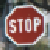

In [228]:
example_images = os.listdir(BASE_PATH + 'train/stop')
img = load_img(BASE_PATH + 'train/stop/' + example_images[0], target_size=(50, 50))
img

In [229]:
x = np.array(img)
x.shape

(50, 50, 3)

## Model

In [230]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [231]:
train_dir = os.path.join(BASE_PATH, 'train')
valid_dir = os.path.join(BASE_PATH, 'valid')
test_dir = os.path.join(BASE_PATH, 'test')

In [232]:
train_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    class_mode="categorical",
    batch_size=32
)

Found 34799 images belonging to 43 classes.


In [233]:
val_gen = ImageDataGenerator(rescale=1./255)

val_ds = val_gen.flow_from_directory(
    valid_dir,
    target_size=(32, 32),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 4410 images belonging to 43 classes.


In [234]:
num_indeces = len(train_ds.class_indices)
num_indeces

43

In [235]:
X, y = next(train_ds)

In [236]:
y[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Define model

In [237]:
def make_model(learning_rate=0.01):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_indeces, activation='softmax'))
  
  #########################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss_function = keras.losses.CategoricalCrossentropy(from_logits=False)

  model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy']
  )
  
  return model

### Try params variations

In [238]:
learning_rates = [0.1, 0.01, 0.001]
scores = {}

In [239]:
for index, lr in enumerate(learning_rates):
  print('Learning rate:', lr)

  model = make_model(lr)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds)
  scores[index] = history.history

  model.summary()

  print()
  print()

Learning rate: 0.1
Epoch 1/10
1088/1088 [==============================] - 40s 36ms/step - loss: 4.4032 - accuracy: 0.0540 - val_loss: 3.5835 - val_accuracy: 0.0476
Epoch 2/10
1088/1088 [==============================] - 39s 36ms/step - loss: 3.5040 - accuracy: 0.0524 - val_loss: 3.5694 - val_accuracy: 0.0476
Epoch 3/10
1088/1088 [==============================] - 39s 36ms/step - loss: 3.5021 - accuracy: 0.0580 - val_loss: 3.5671 - val_accuracy: 0.0544
Epoch 4/10
1088/1088 [==============================] - 39s 36ms/step - loss: 3.5041 - accuracy: 0.0542 - val_loss: 3.5783 - val_accuracy: 0.0476
Epoch 5/10
1088/1088 [==============================] - 39s 36ms/step - loss: 3.5034 - accuracy: 0.0542 - val_loss: 3.5784 - val_accuracy: 0.0476
Epoch 6/10
1088/1088 [==============================] - 39s 35ms/step - loss: 3.5021 - accuracy: 0.0549 - val_loss: 3.5940 - val_accuracy: 0.0544
Epoch 7/10
1088/1088 [==============================] - 39s 36ms/step - loss: 3.5040 - accuracy: 0.0540 -

### Model scores

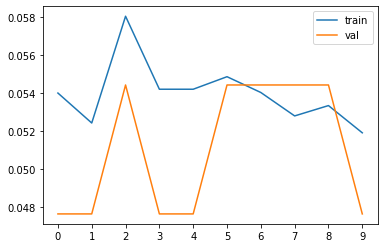

In [240]:
plt.plot(scores[0]['accuracy'], label='train')
plt.plot(scores[0]['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()
print()
print()

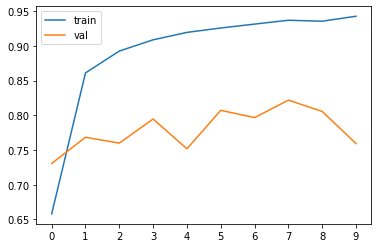

In [241]:
plt.plot(scores[1]['accuracy'], label='train')
plt.plot(scores[1]['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()
print()
print()

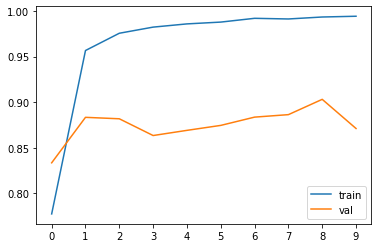

In [242]:
plt.plot(scores[2]['accuracy'], label='train')
plt.plot(scores[2]['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()
print()
print()

## Augmentation

In [243]:
train_aug = ImageDataGenerator(
  rescale=1./255,
  shear_range=10,
  rotation_range=5,
  zoom_range=0.1,
  #horizontal_flip=True,
  #fill_mode='nearest'
)

train_ds = train_aug.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    class_mode="categorical",
    batch_size=20,
    shuffle=True
)

val_gen = ImageDataGenerator(rescale=1./255)

val_ds = val_gen.flow_from_directory(
    valid_dir,
    target_size=(32, 32),
    class_mode="categorical",
    batch_size=20,
    shuffle=True
)

Found 34799 images belonging to 43 classes.
Found 4410 images belonging to 43 classes.


In [244]:
model = make_model(0.001)

history = model.fit(
  train_ds,
  steps_per_epoch=100,
  epochs=10,
  validation_data=val_ds,
  validation_steps=50
)

score = history.history
model.summary()

Epoch 1/10
100/100 [==============================] - 5s 43ms/step - loss: 3.1633 - accuracy: 0.2090 - val_loss: 2.8239 - val_accuracy: 0.3020
Epoch 2/10
100/100 [==============================] - 4s 42ms/step - loss: 2.3889 - accuracy: 0.3922 - val_loss: 2.2394 - val_accuracy: 0.4150
Epoch 3/10
100/100 [==============================] - 4s 42ms/step - loss: 1.8169 - accuracy: 0.5188 - val_loss: 1.8410 - val_accuracy: 0.5010
Epoch 4/10
100/100 [==============================] - 4s 42ms/step - loss: 1.4651 - accuracy: 0.5845 - val_loss: 1.6297 - val_accuracy: 0.5480
Epoch 5/10
100/100 [==============================] - 4s 42ms/step - loss: 1.1294 - accuracy: 0.6865 - val_loss: 1.3906 - val_accuracy: 0.6550
Epoch 6/10
100/100 [==============================] - 4s 41ms/step - loss: 0.9943 - accuracy: 0.7325 - val_loss: 1.2268 - val_accuracy: 0.6430
Epoch 7/10
100/100 [==============================] - 4s 42ms/step - loss: 0.8580 - accuracy: 0.7644 - val_loss: 1.1109 - val_accuracy: 0.7020

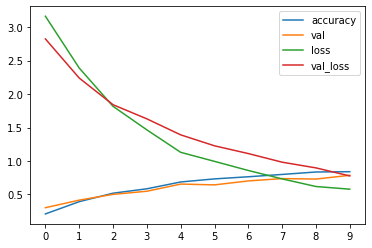

In [245]:
plt.plot(score['accuracy'], label='accuracy')
plt.plot(score['val_accuracy'], label='val')
plt.plot(score['loss'], label='loss')
plt.plot(score['val_loss'], label='val_loss')
plt.xticks(np.arange(10))
plt.legend()

In [246]:
np.mean(score['accuracy']), np.median(score['accuracy']), np.std(score['loss'])

(0.6362337693572044, 0.7095000147819519, 0.807515269088743)

## Test model

In [247]:
os.listdir(BASE_PATH + 'test/speed_limit_50kmh')[:10]

['img_2103.png',
 'img_7974.png',
 'img_6654.png',
 'img_12404.png',
 'img_393.png',
 'img_4506.png',
 'img_7936.png',
 'img_1247.png',
 'img_8369.png',
 'img_3366.png']

In [248]:
from flask import request as request_f
from flask import jsonify
from urllib import request
from io import BytesIO

In [249]:
def load_img_from_url(url):
    print(url)
    with request.urlopen(url) as url:
        f = BytesIO(url.read())

    img = Image.open(f)
    return img

def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [250]:
def predict(url):
  img = load_img_from_url(url)
  img = prepare_image(img, target_size=(32, 32))

  x = np.array(img)
  X = np.array([x])
  X = prepare_input(X)

  preds = model.predict(X).round(3)

  float_predictions = preds[0].tolist()

  return dict(zip(categories, float_predictions))

In [251]:
predict('https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/UK_traffic_sign_601.1.svg/2048px-UK_traffic_sign_601.1.svg.png')

https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/UK_traffic_sign_601.1.svg/2048px-UK_traffic_sign_601.1.svg.png


{'ahead_only': 0.0,
 'beware_of_icesnow': 0.0,
 'bicycles_crossing': 0.0,
 'bumpy_road': 0.0,
 'children_crossing': 0.0,
 'dangerous_curve_to_the_left': 0.0,
 'dangerous_curve_to_the_right': 0.0,
 'double_curve': 0.0,
 'end_of_all_speed_and_passing_limits': 0.0,
 'end_of_no_passing': 0.0,
 'end_of_no_passing_by_vehicles_over_3.5_metric_tons': 0.0,
 'end_of_speed_limit_80kmh': 0.0,
 'general_caution': 0.0,
 'go_straight_or_left': 0.0,
 'go_straight_or_right': 0.0,
 'keep_left': 0.0,
 'keep_right': 0.0,
 'no_entry': 0.0,
 'no_passing': 0.0,
 'no_passing_for_vehicles_over_3.5_metric_tons': 0.0,
 'no_vehicles': 0.0,
 'pedestrians': 0.0,
 'priority_road': 0.0,
 'right-of-way_at_the_next_intersection': 0.0,
 'road_narrows_on_the_right': 0.0,
 'road_work': 0.0010000000474974513,
 'roundabout_mandatory': 0.0,
 'slippery_road': 0.0,
 'speed_limit_100kmh': 0.0,
 'speed_limit_120kmh': 0.0,
 'speed_limit_20kmh': 0.0,
 'speed_limit_30kmh': 0.0,
 'speed_limit_50kmh': 0.0,
 'speed_limit_60kmh': 0.0,


## Save model

In [252]:
from google.colab import files

In [253]:
model_file = BASE_PATH + 'traffic-sign-model.h5'

In [254]:
model.save(model_file)

In [255]:
files.download(model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>